In [15]:
import pandas as pd

df = pd.read_excel('META1.xlsx')

df

,Date,Open,High,Low,Close,Adj Close,Volume,ROE,Price/Book,Profit Margin,EPS
0,2015-12-23,105.889999,106.110001,103.860001,104.629997,104.629997,19599700,0.0728,0.0610,0.1764,0.0333
1,2015-12-24,104.739998,105.320000,104.500000,105.019997,105.019997,6501800,0.0728,0.0610,0.1764,0.0333
2,2015-12-28,105.019997,105.980003,104.529999,105.930000,105.930000,13069700,0.0728,0.0610,0.1764,0.0333
3,2015-12-29,106.419998,107.739998,106.250000,107.260002,107.260002,17179900,0.0728,0.0610,0.1764,0.0333
4,2015-12-30,107.000000,107.250000,106.059998,106.220001,106.220001,13115000,0.0728,0.0610,0.1764,0.0333
...,...,...,...,...,...,...,...,...,...,...,...
1758,2022-12-16,120.230003,123.309998,118.820000,119.430000,119.430000,67045000,0.2316,0.0291,0.2441,-0.4907
1759,2022-12-19,116.830002,117.800003,114.330002,114.480003,114.480003,29769900,0.2316,0.0291,0.2441,-0.4907
1760,2022-12-20,113.260002,117.330002,112.459999,117.089996,117.089996,28742500,0.2316,0.0291,0.2441,-0.4907
1761,2022-12-21,116.699997,120.339996,115.620003,119.760002,119.760002,20392800,0.2316,0.0257,0.2441,-0.4907


In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense



# Extract the closing price and scale the values between 0 and 1
close_vals = df["Close"].values.reshape(-1, 1)
scaler = MinMaxScaler()
close_vals_scaled = scaler.fit_transform(close_vals)

# Split the data into training and testing sets
train_size = int(len(close_vals_scaled) * 0.8)
test_size = len(close_vals_scaled) - train_size
train_data, test_data = close_vals_scaled[0:train_size,:], close_vals_scaled[train_size:len(close_vals_scaled),:]

# Function to create a data set with a specific lookback window
def create_dataset(data, look_back=1):
    data_x, data_y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        data_x.append(a)
        data_y.append(data[i + look_back, 0])
    return np.array(data_x), np.array(data_y)

# Create the training and testing datasets with a lookback window of 10
look_back = 10
train_x, train_y = create_dataset(train_data, look_back)
test_x, test_y = create_dataset(test_data, look_back)

# Reshape the data for the LSTM model
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model to the training data
model.fit(train_x, train_y, epochs=100, batch_size=1, verbose=2)

# Make predictions on the test data
predictions = model.predict(test_x)

# Scale the predictions back to their original values
predictions = scaler.inverse_transform(predictions)

# Calculate the mean squared error of the predictions
mse = np.mean((predictions - test_y)**2)
print(f"Mean squared error: {mse}")


Epoch 1/100
1399/1399 - 5s - loss: 0.0026 - 5s/epoch - 3ms/step
Epoch 2/100
1399/1399 - 3s - loss: 6.0834e-04 - 3s/epoch - 2ms/step
Epoch 3/100
1399/1399 - 3s - loss: 5.0125e-04 - 3s/epoch - 2ms/step
Epoch 4/100
1399/1399 - 3s - loss: 5.4896e-04 - 3s/epoch - 2ms/step
Epoch 5/100
1399/1399 - 3s - loss: 4.0206e-04 - 3s/epoch - 2ms/step
Epoch 6/100
1399/1399 - 3s - loss: 4.1832e-04 - 3s/epoch - 2ms/step
Epoch 7/100
1399/1399 - 3s - loss: 3.6017e-04 - 3s/epoch - 2ms/step
Epoch 8/100
1399/1399 - 3s - loss: 3.6313e-04 - 3s/epoch - 2ms/step
Epoch 9/100
1399/1399 - 3s - loss: 3.8085e-04 - 3s/epoch - 2ms/step
Epoch 10/100
1399/1399 - 3s - loss: 3.8467e-04 - 3s/epoch - 2ms/step
Epoch 11/100
1399/1399 - 3s - loss: 3.5109e-04 - 3s/epoch - 2ms/step
Epoch 12/100
1399/1399 - 3s - loss: 3.3841e-04 - 3s/epoch - 2ms/step
Epoch 13/100
1399/1399 - 4s - loss: 3.5639e-04 - 4s/epoch - 3ms/step
Epoch 14/100
1399/1399 - 3s - loss: 3.4661e-04 - 3s/epoch - 2ms/step
Epoch 15/100
1399/1399 - 3s - loss: 3.1070e-04 

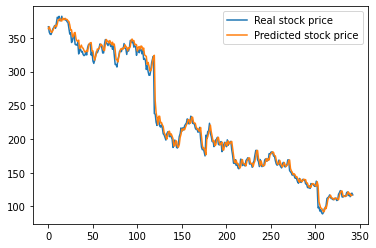

In [17]:
import matplotlib.pyplot as plt

# Create a list of the real stock prices
real_prices = df["Close"][train_size + look_back:].values

# Plot the real and predicted stock prices
plt.plot(real_prices, label="Real stock price")
plt.plot(predictions, label="Predicted stock price")
plt.legend()
plt.show()


In [18]:
# Calculate the mean absolute error of the predictions
mae = np.mean(np.abs(predictions - test_y))
print(f"Mean absolute error: {mae}")

# Calculate the root mean squared error of the predictions
rmse = np.sqrt(mse)
print(f"Root mean squared error: {rmse}")

# Calculate the mean squared error of the predictions
mse = np.mean((predictions - test_y)**2)
print(f"Mean squared error: {mse}")


Mean absolute error: 229.36175638151124
Root mean squared error: 245.8991035628269
Mean squared error: 60466.36913300187


In [19]:
# Use the model to make predictions for the next 5 days
prediction_days = 33
prediction = model.predict(test_x[-prediction_days:])

# Calculate the difference between the predicted and actual closing prices
diffs = prediction - test_y[-prediction_days:]

# Calculate the percentage change between the predicted and actual closing prices
pct_changes = diffs / test_y[-prediction_days:]

# Calculate the average daily return
avg_daily_return = np.mean(pct_changes)

# Calculate the total return
total_return = avg_daily_return * prediction_days
print(f"Total return: {total_return:.2f}%")


2/2 [==============================] - 0s 6ms/step
Total return: 13.98%


In [20]:
# Use the model to make predictions for the next 33 days
prediction_days = 33
prediction = model.predict(test_x[-prediction_days:])

# Calculate the difference between the predicted and actual closing prices
diffs = prediction - test_y[-prediction_days:]

# Calculate the percentage change between the predicted and actual closing prices
pct_changes = diffs / test_y[-prediction_days:]

# Calculate the average daily return
avg_daily_return = np.mean(pct_changes)

# Calculate the number of days in a year
days_per_year = 365

# Calculate the annual return
annual_return = avg_daily_return * days_per_year
print(f"Annual return: {annual_return:.2f}%")


2/2 [==============================] - 0s 7ms/step
Annual return: 154.62%


In [28]:
df2 = df[["Date","Close"]][train_size + look_back:]
df2 = df2.iloc[1:]
df2['Predictions']=predictions
df2.to_excel('excel2.xlsx')
df2

,Date,Close,Predictions
1421,2021-08-17,358.450012,363.672852
1422,2021-08-18,355.450012,366.526550
1423,2021-08-19,355.119995,362.192871
1424,2021-08-20,359.369995,358.932312
1425,2021-08-23,363.350006,358.465363
...,...,...,...
1758,2022-12-16,119.430000,121.615036
1759,2022-12-19,114.480003,118.039452
1760,2022-12-20,117.089996,119.193268
1761,2022-12-21,119.760002,115.793808
